/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:21:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


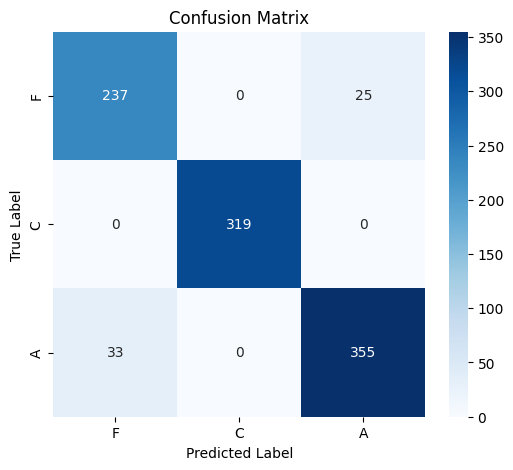

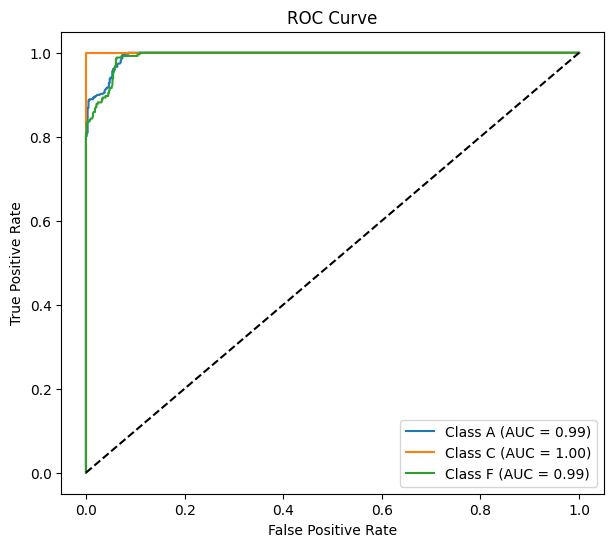

Accuracy: 0.9401
F1 Score: 0.9403
Cohen's Kappa: 0.9092
Sensitivity: [0.91494845 1.         0.90458015]
Specificity: [0.9569707401032702, 1.0, 0.9533239038189534]
False Discovery Rate (FDR): [0.06578947368421052, 0.0, 0.12222222222222222]
Negative Predictive Value (NPV): [0.9439728353140917, 1.0, 0.9642346208869814]
Positive Predictive Value (PPV): [0.93421053 1.         0.87777778]


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
eeg_data = pd.read_csv("/content/drive/MyDrive/EEG/final_data2.csv")
participants = pd.read_csv("/content/drive/MyDrive/EEG/SET/participants.tsv", sep="\t")

data_df = eeg_data
labels_df = participants

# Merge datasets
merged_df = data_df.merge(labels_df, on="participant_id", suffixes=("_eeg", "_meta"))
merged_df.drop(columns=["Group_eeg"], inplace=True)

# Encode categorical features
le_channel = LabelEncoder()
le_band = LabelEncoder()
le_gender = LabelEncoder()
le_group = LabelEncoder()

merged_df["Channel"] = le_channel.fit_transform(merged_df["Channel"])
merged_df["Band"] = le_band.fit_transform(merged_df["Band"])
merged_df["Gender"] = le_gender.fit_transform(merged_df["Gender"])
merged_df["Group"] = le_group.fit_transform(merged_df["Group_meta"])
merged_df.drop(columns=["participant_id", "Group_meta"], inplace=True)

# Define features and target
X = merged_df.drop(columns=["Group"])
y = merged_df["Group"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42,
                          n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
sensitivity = recall
specificity = []
fdr = []
npv = []
ppv = precision

for i in range(len(conf_matrix)):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    fn = conf_matrix[i, :].sum() - conf_matrix[i, i]
    tp = conf_matrix[i, i]

    specificity.append(tn / (tn + fp) if (tn + fp) != 0 else 0)
    fdr.append(fp / (fp + tp) if (fp + tp) != 0 else 0)
    npv.append(tn / (tn + fn) if (tn + fn) != 0 else 0)

# ROC Curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(set(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix[::-1, ::-1], annot=True, fmt="d", cmap="Blues", xticklabels=le_group.classes_[::-1], yticklabels=le_group.classes_[::-1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
plt.figure(figsize=(7, 6))
for i in range(len(set(y_test))):
    plt.plot(fpr[i], tpr[i], label=f"Class {le_group.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Print evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"False Discovery Rate (FDR): {fdr}")
print(f"Negative Predictive Value (NPV): {npv}")
print(f"Positive Predictive Value (PPV): {ppv}")
